<a href="https://colab.research.google.com/github/fredericpoitevin/tseries-deconvolution/blob/master/Deconvolution_of_Michael_coronavirus_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in the following scenario:
We have access to two cumulative time-series that we call cause (or _cases_ $C(t)$ the total number of cases at time $t$) and consequence (or _deaths_ $D(t) $ the total number of deaths at time $t$). We assume that consequence is cause convolved with an unknown kernel $K$, and we are interested in inferring the kernel function, or at least its parameters.

Formally, 

$$\frac{\partial D}{\partial \tau}|_{\tau=t} = \sum_{s=0}^{t} K(t-s)\frac{\partial C}{\partial \tau}|_{\tau=s}$$

We have access to samples of the cumulative time-series at fixed time intervals $\Delta t$, we can thus discretize the above equation with finite difference. For $i \geq 1$, we introduce $f_{i} = \frac{F(i\Delta t) - F((i-1)\Delta t)}{\Delta t}$:

$$d_{i} = \sum_{j=1}^{i}k_{ij}c_{j}$$

# Dataset curated by Michael
We recommend going through the **Illustrative example** below before reading this.

We begin here by importing the data and zero-pad it before the time origin.

In [3]:
uploaded = files.upload()

Saving tseries_sigmoid-v2.csv to tseries_sigmoid-v2.csv


In [4]:
data        = np.genfromtxt('/content/tseries_sigmoid-v2.csv', delimiter=',', comments='#')
ndays       = data.shape[0]
data_pad    = np.zeros(data.shape)
data_padded = np.stack((data_pad, data), axis=0).reshape(2*data.shape[0], data.shape[1])
cases  = data_padded[:,2]
deaths = data_padded[:,3]
print('Total number of days centered on the time origin: {}'.format(data_padded.shape[0]))

Total number of days centered on the time origin: 208


## Kernel extraction

Having loaded the cases and deaths, we proceed to find the convolution kernel between the two:

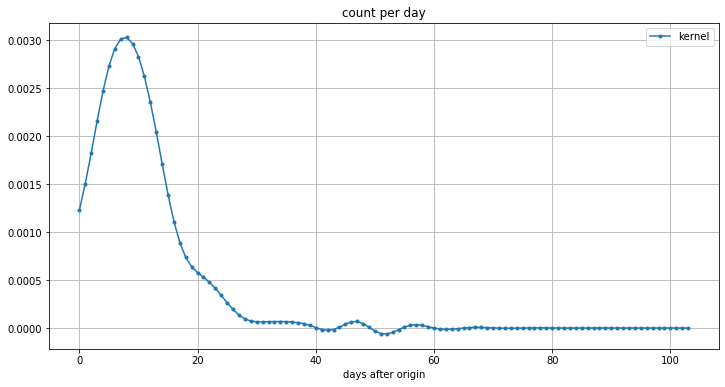

In [5]:
kernel = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e6)
display(ndays, c=kernel, labels=['kernel'], show_cumul=False)

We can measure the discrepancy between the actual deaths and the ones computed by convoluting the cases with the newly obtained kernel:

>>> RMS = 2.67e+00
>>> Smoothness = 8.89e-08
>>> SCORE = 2.67e+00


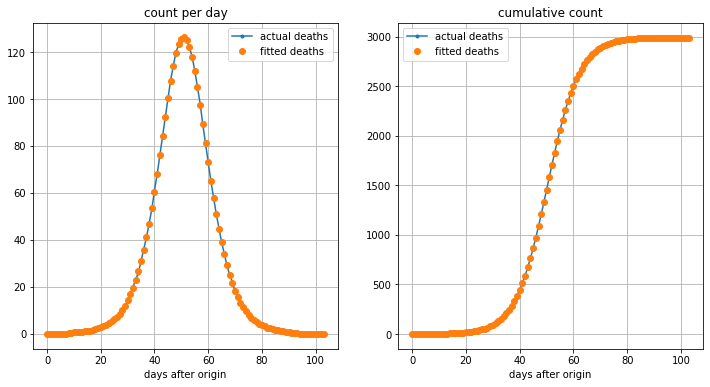

In [6]:
rms, smoothness, score = measure_rms(ndays, c=cases, k=kernel, d=deaths)

We explore around the chosen SNR value to refine our SNR choice to trade between a good fit and a smooth kernel

NSR = 100000.0
>>> RMS = 2.57e+00
>>> Smoothness = 5.75e-07
>>> SCORE = 2.57e+00


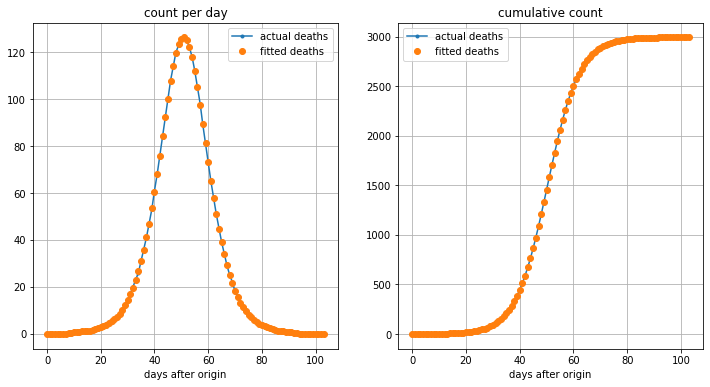

NSR = 158489.3192461114
>>> RMS = 2.58e+00
>>> Smoothness = 3.50e-07
>>> SCORE = 2.58e+00


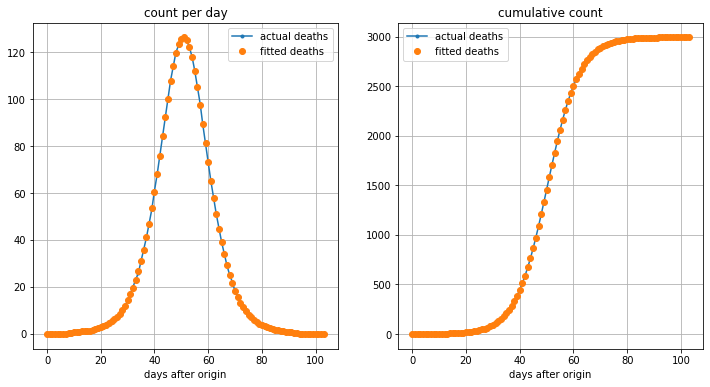

NSR = 251188.6431509582
>>> RMS = 2.60e+00
>>> Smoothness = 2.20e-07
>>> SCORE = 2.60e+00


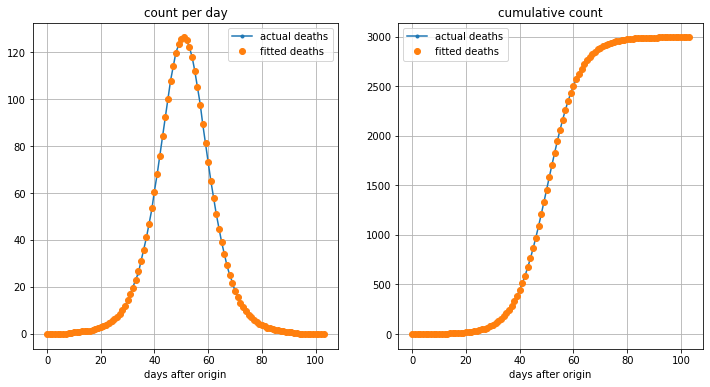

NSR = 398107.1705534969
>>> RMS = 2.62e+00
>>> Smoothness = 1.48e-07
>>> SCORE = 2.62e+00


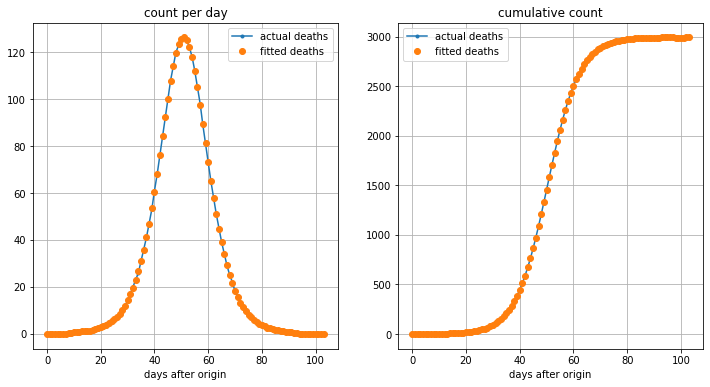

NSR = 630957.344480193
>>> RMS = 2.64e+00
>>> Smoothness = 1.09e-07
>>> SCORE = 2.64e+00


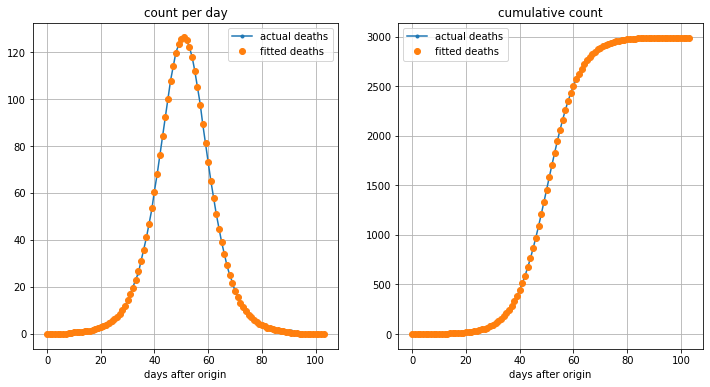

NSR = 1000000.0
>>> RMS = 2.67e+00
>>> Smoothness = 8.89e-08
>>> SCORE = 2.67e+00


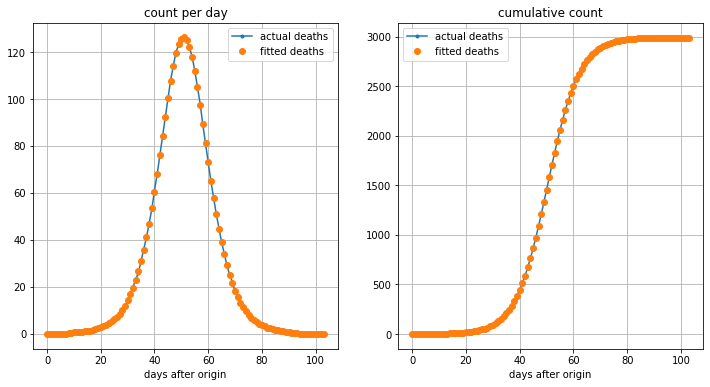

NSR = 1584893.1924611141
>>> RMS = 2.71e+00
>>> Smoothness = 7.75e-08
>>> SCORE = 2.71e+00


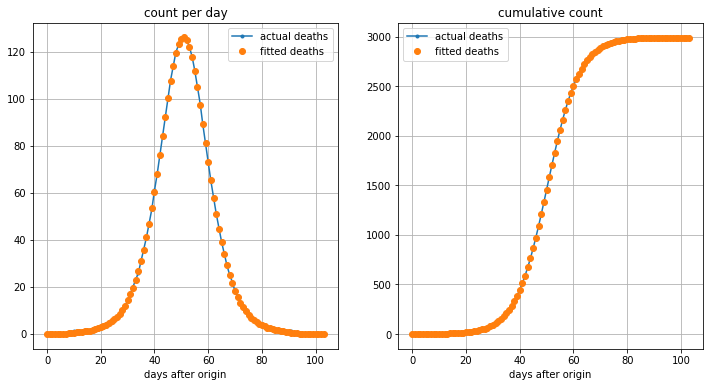

NSR = 2511886.4315095823
>>> RMS = 2.78e+00
>>> Smoothness = 7.02e-08
>>> SCORE = 2.78e+00


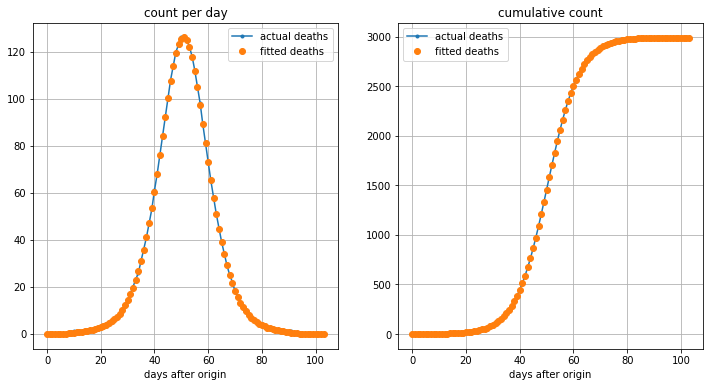

NSR = 3981071.7055349695
>>> RMS = 2.93e+00
>>> Smoothness = 6.47e-08
>>> SCORE = 2.93e+00


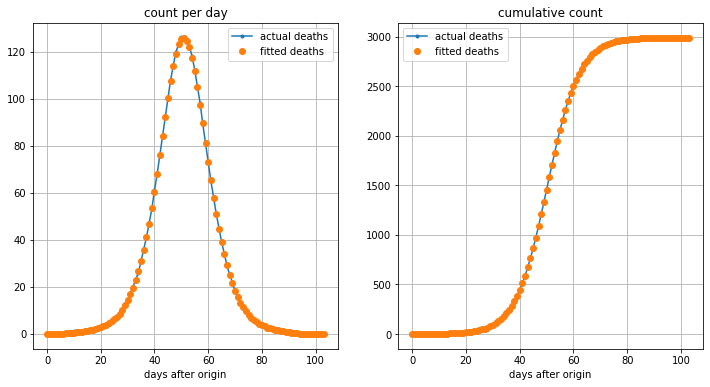

NSR = 6309573.44480193
>>> RMS = 3.24e+00
>>> Smoothness = 5.97e-08
>>> SCORE = 3.24e+00


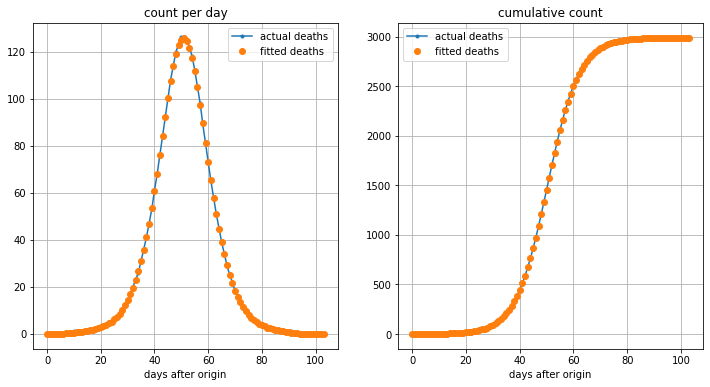

NSR = 10000000.0
>>> RMS = 3.84e+00
>>> Smoothness = 5.49e-08
>>> SCORE = 3.84e+00


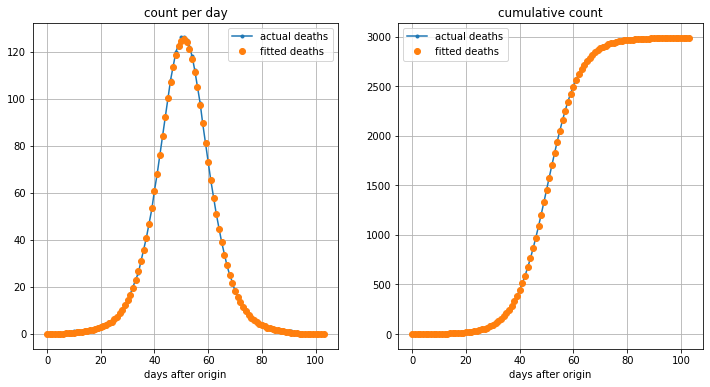

In [7]:
nsr_list = np.logspace(5, 7, num=11)
rms_list = []
smoothness_list = []
score_list = []
#
for nsr in nsr_list:
  print('NSR = {}'.format(nsr))
  kernel = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=nsr)
  rms, smoothness, score = measure_rms(ndays, c=cases, k=kernel, d=deaths)
  rms_list.append(rms)
  smoothness_list.append(smoothness)
  score_list.append(score)

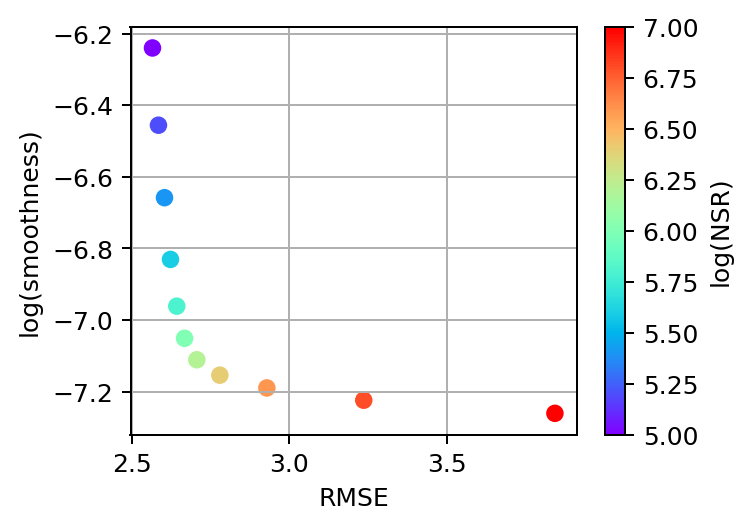

In [8]:
fig, ax = plt.subplots(figsize=(4,3),dpi=180)
sc = ax.scatter(rms_list, np.log10(smoothness_list), c=np.log10(nsr_list), cmap='rainbow')
ax.set_xlabel('RMSE')
ax.set_ylabel('log(smoothness)')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('log(NSR)')
plt.grid()
plt.show()

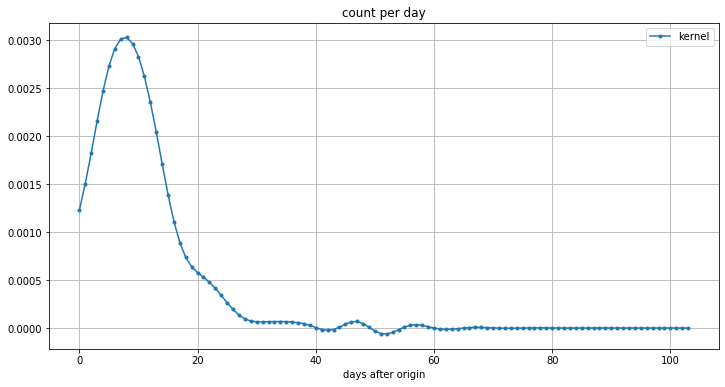

In [9]:
kernel = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e6)
display(ndays, c=kernel, labels=['kernel'], show_cumul=False)

## Kernel fitting

Now that we are happy with the kernel we extracted, we try to interpret it as a known distribution...

[3.23647199e-03 5.91248174e+00 1.11788192e+02]


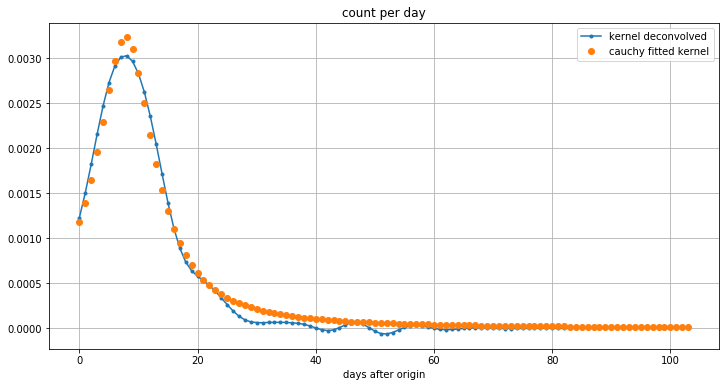

>>> RMS = 4.00e+01
>>> Smoothness = 1.15e-07
>>> SCORE = 4.00e+01


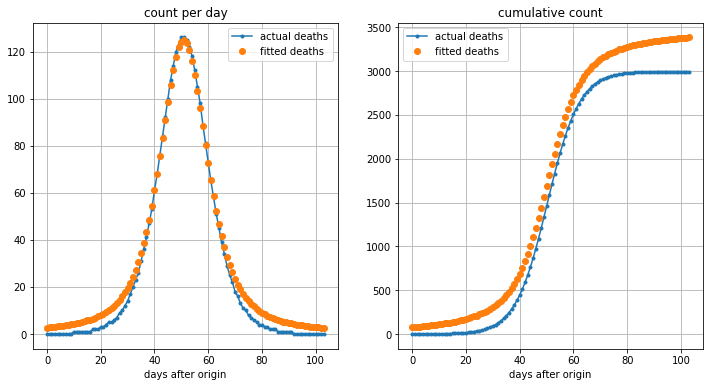

In [10]:
kernel_cauchy_fitted, params = fit_kernel(kernel, cauchy, p0=(0.003,5,ndays+10))
print(params)
display(ndays, c=kernel, d=kernel_cauchy_fitted, 
        labels=['kernel deconvolved','cauchy fitted kernel'], show_cumul=False)
rms_cauchy_fitted = measure_rms(ndays, c=cases, k=kernel_cauchy_fitted, d=deaths)

In [0]:
write_kernel_to_file('cauchy_fit.csv',
                     first_line='# Cauchy kernel fit\n',
                     second_line='# initial parameters: I={:.2e}, sigma={:.2e}, center={:.2e}\n'.format(0.003,5,10),
                     third_line='# final parameters  : I={:.2e}, sigma={:.2e}, center={:.2e}\n'.format(params[0], params[1], params[2]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_cauchy_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_cauchy_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_cauchy_fitted, cases,'same'))

[2.93249227e-03 6.39229780e+00 1.11785982e+02]


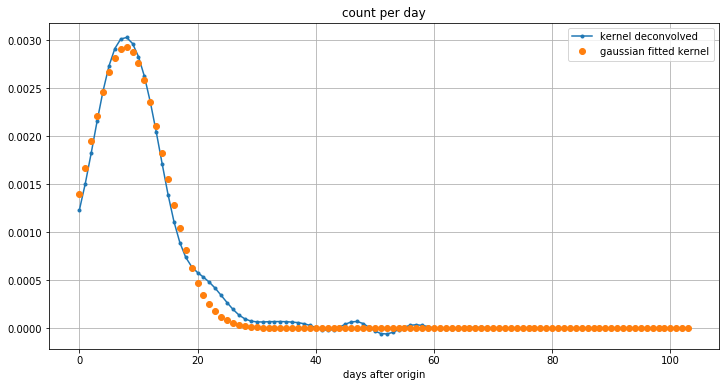

>>> RMS = 2.85e+01
>>> Smoothness = 4.33e-08
>>> SCORE = 2.85e+01


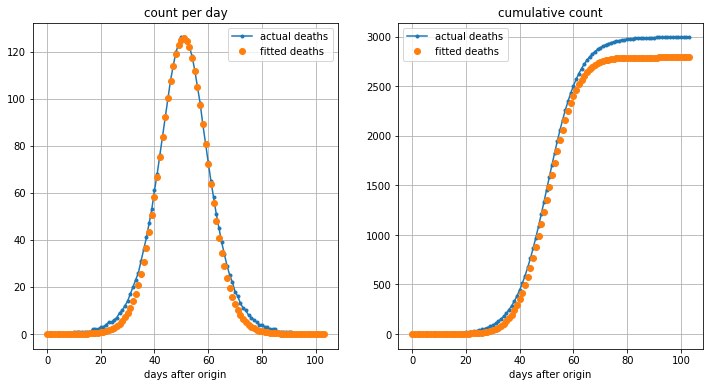

In [28]:
kernel_gaussian_fitted, params = fit_kernel(kernel, gaussian, p0=(0.003,5,ndays+10))
print(params)
display(ndays, c=kernel, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)
rms_gaussian_fitted = measure_rms(ndays, c=cases, k=kernel_gaussian_fitted, d=deaths)

In [0]:
write_kernel_to_file('one-gaussian_fit.csv',
                     first_line='# Single gaussian kernel fit\n',
                     second_line='# initial parameters: I={:.2e}, sigma={:.2e}, center={:.2e}\n'.format(0.003,5,10),
                     third_line='# final parameters  : I={:.2e}, sigma={:.2e}, center={:.2e}\n'.format(params[0], params[1], params[2]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_gaussian_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_gaussian_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_gaussian_fitted, cases,'same'))

[2.98023640e-03 2.89489262e-04 6.13489216e+00 2.74849007e+00
 1.11680220e+02 1.27129179e+02]


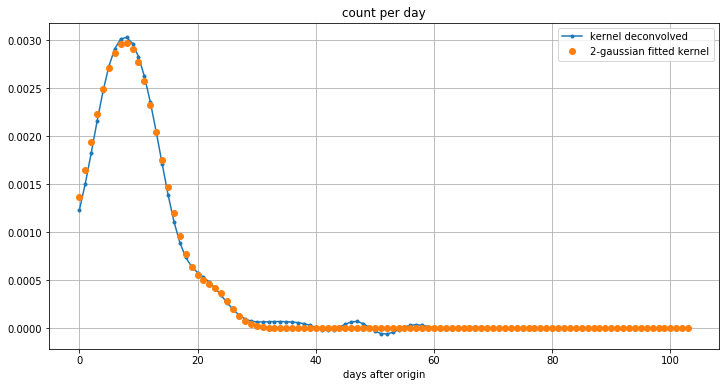

>>> RMS = 2.50e+01
>>> Smoothness = 5.53e-08
>>> SCORE = 2.50e+01


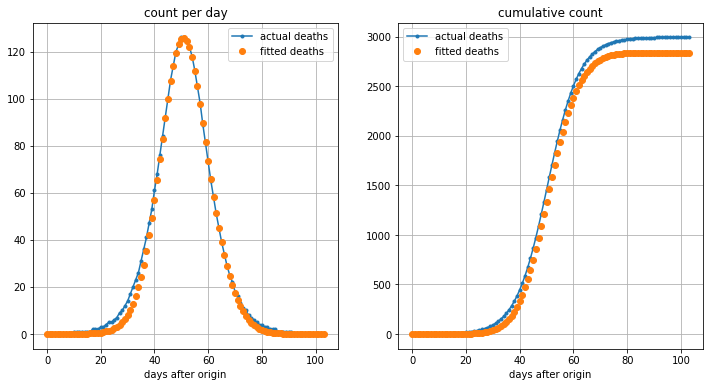

In [30]:
kernel_2gaussian_fitted, params = fit_kernel(kernel, gaussian_sum, p0=(0.003,0.0003,
                                                                       5,5,
                                                                       ndays+5,ndays+20))
print(params)
display(ndays, c=kernel, d=kernel_2gaussian_fitted, 
        labels=['kernel deconvolved','2-gaussian fitted kernel'], show_cumul=False)
rms_2gaussian_fitted = measure_rms(ndays, c=cases, k=kernel_2gaussian_fitted, d=deaths)

In [0]:
write_kernel_to_file('two-gaussian_fit.csv',
                     first_line='# Double gaussian kernel fit\n',
                     second_line='# initial parameters: I={:.2e}/{:.2e}, sigma={:.2e}/{:.2e}, center={:.2e}/{:.2e}\n'.format(0.003,0.0003,5,5,5,20),
                     third_line='# final parameters  : I={:.2e}/{:.2e}, sigma={:.2e}/{:.2e}, center={:.2e}/{:.2e}\n'.format(params[0], params[1], 
                                                                                                                            params[2], params[3],
                                                                                                                            params[4]-ndays,params[5]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_2gaussian_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_2gaussian_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_2gaussian_fitted, cases,'same'))

[3.08733059e-04 3.05916961e-03 3.37114989e-04 4.62224380e+00
 5.60438965e+00 3.52895172e+00 9.74140064e+01 1.11850825e+02
 1.26315229e+02]


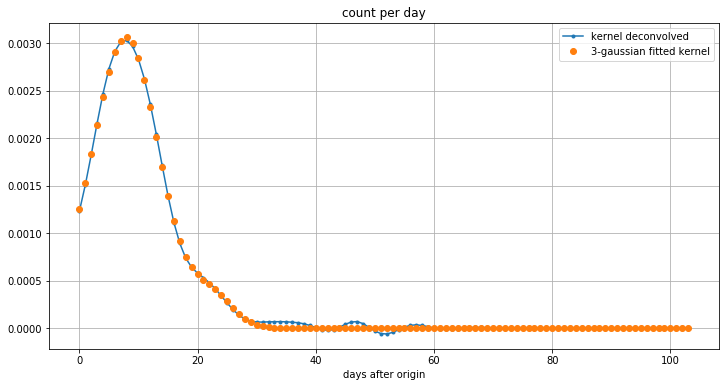

>>> RMS = 8.07e+00
>>> Smoothness = 6.78e-08
>>> SCORE = 8.07e+00


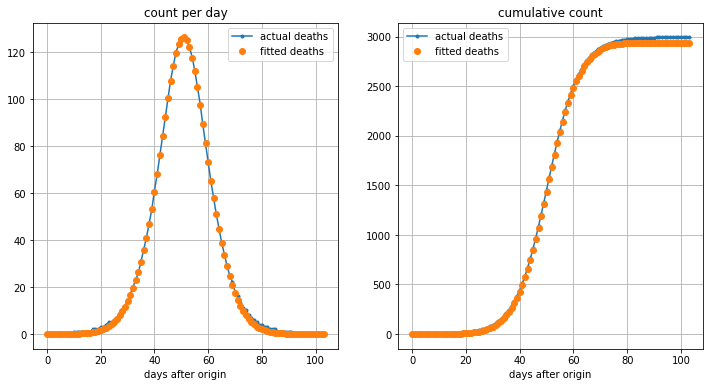

In [32]:
kernel_3gaussian_fitted, params = fit_kernel(kernel, gaussian_sum, p0=(0.0003,0.003,0.0003,
                                                                       5,5,5,
                                                                       ndays,ndays+5,ndays+20))
print(params)
display(ndays, c=kernel, d=kernel_3gaussian_fitted, 
        labels=['kernel deconvolved','3-gaussian fitted kernel'], show_cumul=False)
rms_3gaussian_fitted = measure_rms(ndays, c=cases, k=kernel_3gaussian_fitted, d=deaths)

In [0]:
write_kernel_to_file('three-gaussian_fit.csv',
                     first_line='# Triple gaussian kernel fit\n',
                     second_line='# initial parameters: I={:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}\n'.format(0.0003,0.003,0.0003,5,5,5,0,5,20),
                     third_line='# final parameters  : I={:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}\n'.format(params[0],params[1],params[2],
                                                                                                                                                 params[3],params[4],params[5],
                                                                                                                                                 params[6]-ndays,params[7]-ndays,params[8]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_3gaussian_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_3gaussian_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_3gaussian_fitted, cases,'same'))

[2.28414740e-04 2.89701296e-03 2.58829409e-04 1.61659804e-04
 3.70953526e+00 5.52861445e+00 2.52796593e+00 1.62210969e+01
 9.74726988e+01 1.11811186e+02 1.26090762e+02 1.13057017e+02]


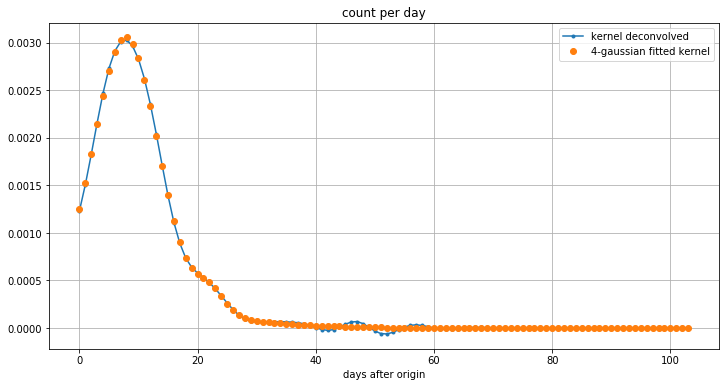

>>> RMS = 3.12e+00
>>> Smoothness = 7.03e-08
>>> SCORE = 3.12e+00


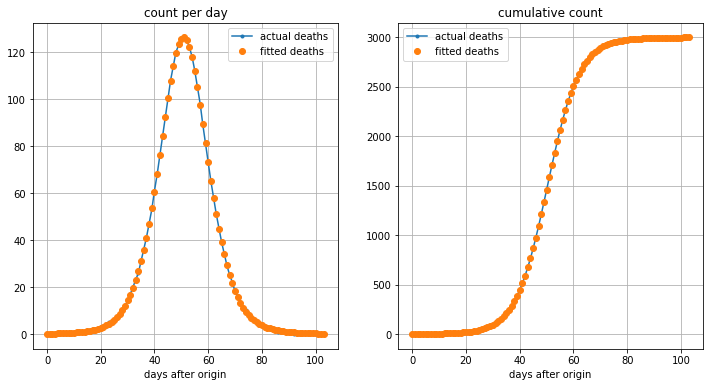

In [37]:
kernel_4gaussian_fitted, params = fit_kernel(kernel, gaussian_sum, p0=(0.0003,0.003,0.0003,0.0001,
                                                                       5,5,5,5,
                                                                       ndays,ndays+5,ndays+20,ndays+20))
print(params)
display(ndays, c=kernel, d=kernel_4gaussian_fitted, 
        labels=['kernel deconvolved','4-gaussian fitted kernel'], show_cumul=False)
rms_4gaussian_fitted = measure_rms(ndays, c=cases, k=kernel_4gaussian_fitted, d=deaths)

In [0]:
write_kernel_to_file('four-gaussian_fit.csv',
                     first_line='# 4-gaussian kernel fit\n',
                     second_line='# initial parameters: I={:.2e}/{:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}/{:.2e}\n'.format(0.0003,0.003,0.0003,0.0001,5,5,5,5,0,5,20,20),
                     third_line='# final parameters  : I={:.2e}/{:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}/{:.2e}\n'.format(params[0],params[1],params[2],params[3],
                                                                                                                                                                      params[4],params[5],params[6],params[7],
                                                                                                                                                                      params[8]-ndays,params[9]-ndays,params[10]-ndays,params[11]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_4gaussian_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_4gaussian_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_4gaussian_fitted, cases,'same'))

[3.04853894e-04 3.05598697e-03 3.43751443e-04 7.14711884e-05
 1.10627909e-04 4.29673526e+00 5.66790514e+00 3.01719212e+00
 3.81322209e+00 1.49202640e+00 9.71553322e+01 1.11844071e+02
 1.26251567e+02 1.37257938e+02 8.28463823e+01]


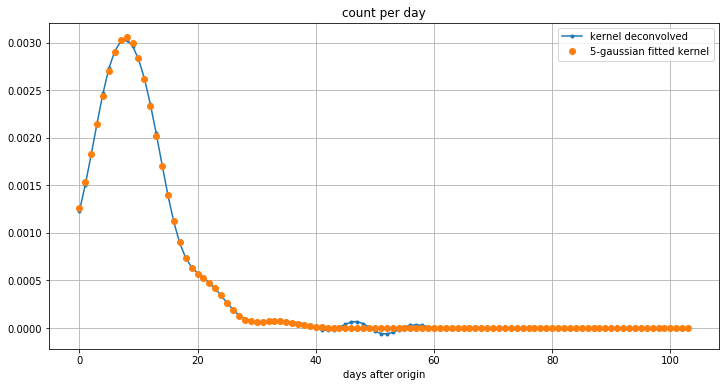

>>> RMS = 3.01e+00
>>> Smoothness = 7.41e-08
>>> SCORE = 3.01e+00


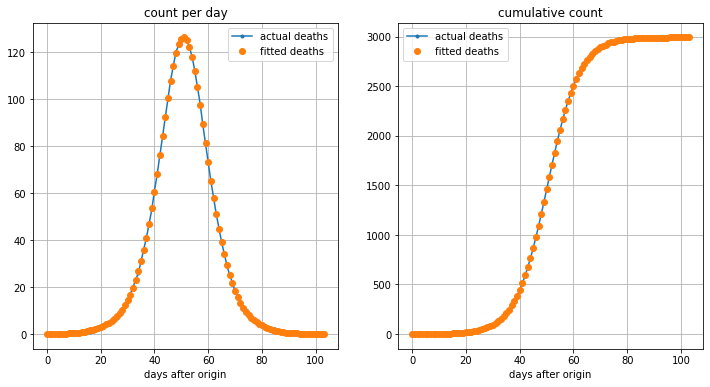

In [39]:
kernel_5gaussian_fitted, params = fit_kernel(kernel, gaussian_sum, p0=(0.0003,0.003,0.0003,0.0001,0.0001,
                                                                       5,5,5,5,5,
                                                                       ndays,ndays+5,ndays+20,ndays+20,ndays+20))
print(params)
display(ndays, c=kernel, d=kernel_5gaussian_fitted, 
        labels=['kernel deconvolved','5-gaussian fitted kernel'], show_cumul=False)
rms_5gaussian_fitted = measure_rms(ndays, c=cases, k=kernel_5gaussian_fitted, d=deaths)

In [0]:
write_kernel_to_file('five-gaussian_fit.csv',
                     first_line='# 5-gaussian kernel fit\n',
                     second_line='# initial parameters: I={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}\n'.format(0.0003,0.003,0.0003,0.0001,0.0001,5,5,5,5,5,0,5,20,20,20),
                     third_line='# final parameters  : I={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}, sigma={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}, center={:.2e}/{:.2e}/{:.2e}/{:.2e}/{:.2e}\n'.format(params[0],params[1],params[2],params[3],params[4],
                                                                                                                                                                                           params[5],params[6],params[7],params[8],params[9],
                                                                                                                                                                                           params[10]-ndays,params[11]-ndays,params[12]-ndays,params[13]-ndays,params[14]-ndays),
                     fourth_line='# RMSE(death vs kernel*case) = {:.2e}\n'.format(rms_5gaussian_fitted[0]),
                     fields='# time-pt , kernel  , kfitted , deaths  , dfitted \n',
                     timestamps=np.arange(ndays), torigin=ndays,
                     kernel=kernel, kernel_fitted=kernel_5gaussian_fitted,
                     deaths=deaths, deaths_fitted=np.convolve(kernel_5gaussian_fitted, cases,'same'))

# Illustrative example

## Synthesizing the dataset

First, let's define the parameters below:

In [0]:
ndays            = 50
cases_amplitude  = 100
cases_center     = 15
cases_width      = 5
kernel_amplitude = 0.05
kernel_center    = 5
kernel_width     = 2

Now let's synthesize the cases time-series as well as the kernel. 

*Important note: we look at the (ndays:2ndays) period of time, but we actually work on the full (0:2ndays) period*

Convolve to predict the deaths, and display the cases and resulting deaths.

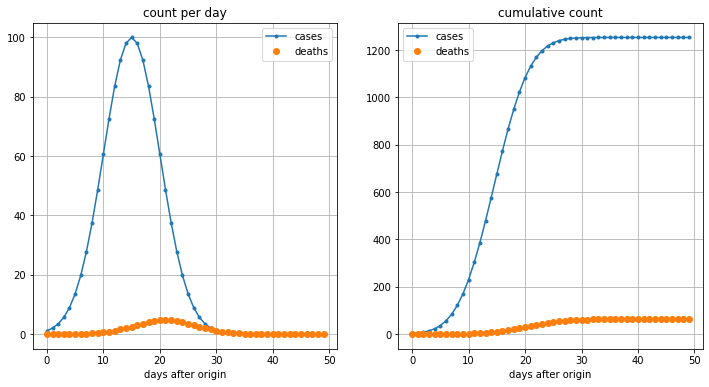

In [0]:
t = define_time_points(ndays)
cases  = synthesize_tseries(t, gaussian, cases_amplitude, cases_width, cases_center)
kernel = synthesize_tseries(t, gaussian, kernel_amplitude, kernel_width, kernel_center, normalize=True)
deaths = np.convolve(kernel, cases, mode='same')
display(ndays, c=cases, d=deaths, labels=['cases','deaths'])

## Kernel deconvolution from synthetic data

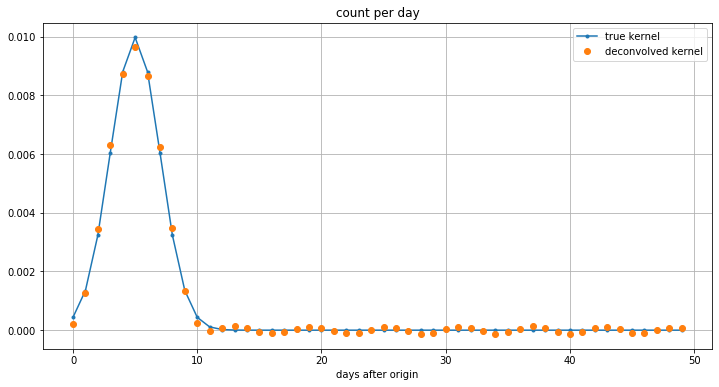

In [0]:
kernel_deconvolved = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e-7)
display(ndays, c=kernel, d=kernel_deconvolved, labels=['true kernel','deconvolved kernel'], show_cumul=False)

Let's now measure the discrepancy between the actual and fitted deaths:

>>> RMS = 0.00002


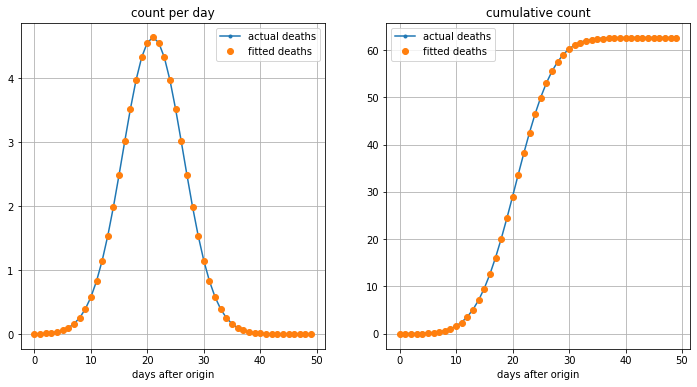

In [0]:
rms = measure_rms(ndays, c=cases, k=kernel_deconvolved, d=deaths)

Let's fit a parametric function to the deconvolved kernel

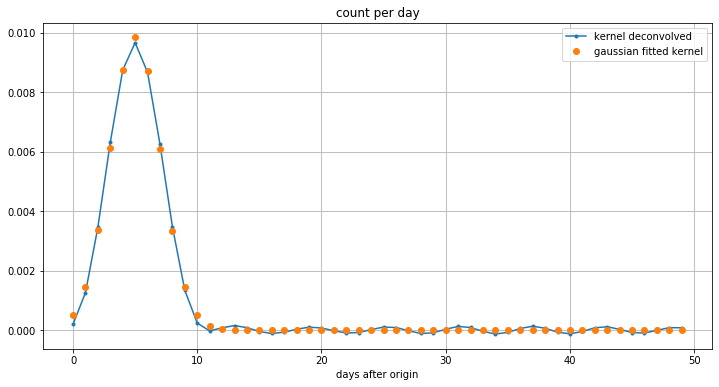

In [0]:
kernel_gaussian_fitted, params = fit_kernel(kernel_deconvolved, gaussian, p0=(0.01,ndays+5,5))
display(ndays, c=kernel_deconvolved, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)


And let's now measure the discrepancy between the actual deaths and the one fitted with the gaussian-fitted kernel:

>>> RMS = 0.10986


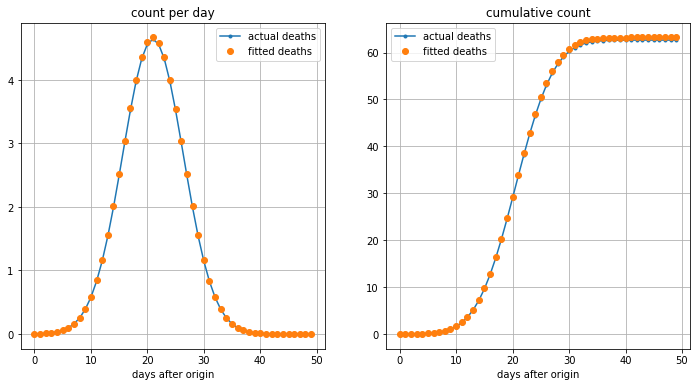

In [0]:
rms = measure_rms(ndays, c=cases, k=kernel_gaussian_fitted, d=deaths)

# Toolkit

In [0]:
# load all libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from scipy.optimize import curve_fit


In [0]:
def fit_kernel(kernel, function, p0=None):
  popt, pcov = curve_fit(function, np.arange(kernel.shape[0]), kernel, p0=p0)
  kernel_fitted = function(np.arange(kernel.shape[0]), *popt)
  return kernel_fitted, popt

def gaussian_sum(x,*params, normalize=False):
  n=np.int(len(params)/3)
  amplitude = params[:n]
  sigma     = params[n:2*n]
  center    = params[2*n:3*n]
  y = np.zeros(x.shape)
  for i in np.arange(n):
    y += gaussian(x, amplitude[i], sigma[i], center[i])
  return y

def gaussian(x, *params, normalize=False):
  amplitude = params[0]
  sigma     = params[1]
  center    = params[2]
  if normalize:
    amplitude /= np.sqrt(2*np.pi)*sigma
  y = amplitude*np.exp(-0.5*((x-center)/sigma)**2)
  return y

def cauchy(x, *params, normalize=False):
  amplitude = params[0]
  sigma     = params[1]
  center    = params[2]
  if normalize:
    amplitude = 1/(np.pi*sigma)
  y = amplitude/(1 + ((x-center)/sigma)**2)
  return y

def define_time_points(ndays):
  """define_time_points(ndays)
  """
  return np.arange(-ndays,ndays)

def synthesize_tseries(t, function, *params, normalize=False):
  """synthesize_tseries(t, function, *params)
  Arguments:
  ---------
  - t: time-points (array. Mandatory)
  - function: shape of the distribution
  - params: parameters of function 
  Returns:
  -------
  tseries: function evaluated at t
  """
  tseries = function(t, *params, normalize=normalize)
  return tseries

def measure_rms(ndays, c=None, k=None, d=None, do_display=True, labels=['actual deaths','fitted deaths']):
  """rms
  """
  d_new = np.convolve(k,c,mode='same')
  rms = np.linalg.norm(d_new[ndays:]-d[ndays:])
  smoothness = np.sum(np.abs(np.convolve(k, [1,-2,1], 'same'))**2)
  print('>>> RMS = {:.2e}\n>>> Smoothness = {:.2e}\n>>> SCORE = {:.2e}'.format(rms, smoothness, rms+smoothness))
  if do_display:
    display(ndays, c=d, d=d_new, labels=labels)
  return rms,smoothness,rms+smoothness

def wiener_deconvolution(ndays,c=None,d=None,nsr=0.0):
  """wiener_deconvolution
  """
  c_fft = np.fft.fft(c)
  d_fft = np.fft.fft(d)
  k_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2 + nsr)
  return np.roll(np.real(np.fft.ifft(k_fft)),ndays-1)

def display(ndays,c=None, d=None, labels=['cause', 'consequence'], show_cumul=True):
  ncol=1
  if show_cumul:
    ncol=2
  trange=np.arange(ndays)
  tzero = ndays
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,ncol,1)
  plt.title('count per day')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,c[tzero:], '.-', label=labels[0])
  if d is not None:
    plt.plot(trange,d[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()
  if show_cumul:
    plt.subplot(1,ncol,2)
    plt.title('cumulative count')
    plt.xlabel('days after origin')
    if c is not None:
      plt.plot(trange,np.cumsum(c)[tzero:], '.-', label=labels[0])
    if d is not None:
      plt.plot(trange,np.cumsum(d)[tzero:], 'o', label=labels[1])
    plt.grid()
    plt.legend()
  plt.show()

def write_kernel_to_file(filename, 
                         first_line='#',
                         second_line='#',
                         third_line='#',
                         fourth_line='#',
                         fields='#',
                         timestamps=None, torigin=0,
                         kernel=None, kernel_fitted=None,
                         deaths=None, deaths_fitted=None,):
  file_test = open('/content/{}'.format(filename), 'w')
  file_test.write('{}'.format(first_line))
  file_test.write('{}'.format(second_line))
  file_test.write('{}'.format(third_line))
  file_test.write('{}'.format(fourth_line))
  file_test.write('{}'.format(fields))
  for t in timestamps: 
    file_test.write('{:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}\n'.format(t,
                                                                      kernel[t+torigin],
                                                                      kernel_fitted[t+torigin],
                                                                      deaths[t+torigin],
                                                                      deaths_fitted[t+torigin]))
  file_test.close()
